Ten hits in a single game can have *very* different results depending how they're distributed --- spread out they can be relatively harmless (unless they're all home runs!), but clustered together and they can cause some serious damage.  There is a general consensus that the distribution of hits comes down to luck, or [clusterluck](https://thepowerrank.com/cluster-luck/), but I can't help but wonder if it's possible to nudge lineups towards more clustering.  <br>
To begin to answer that I thought, why not use a simulation to compare the outcomes of the simplest possible scenarios: lineups with on-base percentages (OBPs) in ascending and descending orders?  <br>
Here I show each step of the simulation, which includes:
- drawing *lineups* of on-base percentages, drawn from a realistic distribution.
- estimating whether the batter makes an out using Bernoulli function, then
- simulating single games in the simplest way possible: 9 innings, 3 outs, on base moves everyone up one spot.
- simulating entire seasons 2500 times.

## Python packages
We start by importing some standard Python packages:

In [155]:
from __future__ import absolute_import, division, print_function
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from scipy.optimize import curve_fit
import sys
import scipy.stats as stats
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
%matplotlib inline

## Download Data
The following file containing batting data (Name, PA, HR, OBP, etc.) was grabbed from [Fangraphs](https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=y&type=8&season=2018&month=0&season1=2018&ind=0) and stored locally. <br>
We use Pandas to read the .csv file into a Dataframe named *leaderboard*.

In [2]:
path_leaderboard = '/data/baseball/Fangraphs/FanGraphs_Leaderboard_Full_2018.csv'
leaderboard = pd.read_csv(path_leaderboard)

Let's see what *leaderboard* contains.

In [3]:
leaderboard_keys = [i for i in leaderboard]
print(leaderboard_keys)
leaderboard.head()

['Name', 'Team', 'G', 'PA', 'HR', 'R', 'RBI', 'SB', 'BB%', 'K%', 'ISO', 'BABIP', 'AVG', 'OBP', 'SLG', 'wOBA', 'wRC+', 'BsR', 'Off', 'Def', 'WAR', 'playerid']


,Name,Team,G,PA,HR,R,RBI,SB,BB%,K%,...,AVG,OBP,SLG,wOBA,wRC+,BsR,Off,Def,WAR,playerid
0,Mookie Betts,Red Sox,136,614,32,129,80,30,13.2 %,14.8 %,...,0.346,0.438,0.640,0.449,185.0,6.9,69.1,11.6,10.4,13611
1,Mike Trout,Angels,140,608,39,101,79,24,20.1 %,20.4 %,...,0.312,0.460,0.628,0.447,191.0,5.0,71.1,4.2,9.8,10155
2,Jose Ramirez,Indians,157,698,39,110,105,34,15.2 %,11.5 %,...,0.270,0.387,0.552,0.391,146.0,12.0,50.6,4.6,8.0,13510
3,Alex Bregman,Astros,157,705,31,105,103,10,13.6 %,12.1 %,...,0.286,0.394,0.532,0.396,157.0,3.4,51.4,-0.6,7.6,17678
4,Francisco Lindor,Indians,158,745,38,129,92,25,9.4 %,14.4 %,...,0.277,0.352,0.519,0.368,130.0,1.2,28.3,21.1,7.6,12916


## Define Simulation Functions
Next, we define functions that get called by the simulations.  <br> 

The function *gauss* is defined for fitting of Gaussians to histograms. <br>

In [6]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

We begin by defining a realistic distrubution of on-base percentages (OBPs), *define_P*,  to draw from in later funciton.  A simple solution adopted here is to fit a Gaussian to the OBPs found in *leaderboard*, i.e., the *actual* OPBs. 
Note, to make sure that the modeled lineup is not dominated by transient players, we define lower limits for OBP and minimum plate appearances (using stats.truncnorm) as 0.225 and 80, respectively. 

In [87]:
def define_P(leaderboard, lower_obp = 0.225, min_plate_appearances = 80, year = 2018):
    n, bins = np.histogram(leaderboard.OBP[(leaderboard.PA > min_plate_appearances)], 'scott')
    bin_centres = (bins[:-1] + bins[1:])/2
    p0 = [1., 0., 1.]
    coeff, var_matrix = curve_fit(gauss, bin_centres, n, p0=p0)
    print('mean='+str(coeff[1]))
    print('std='+str(coeff[2]))
    upper = 1.0 # Can't reach base more than 100% percent of time
    X = stats.truncnorm(
        (lower_obp - coeff[1]) / coeff[2], (upper - coeff[1]) / coeff[2], loc=coeff[1], scale=coeff[2])
    return X, coeff

We then define *draw_lineup* to build a lineup by calling *define_P*, i.e., randomly drawing OBPs for 9 players.

In [88]:
def draw_lineup(P):
    lineup = {}
    lineup['OBP'] = P.rvs(9)
    return lineup

Check that our distribution of OBPs that we draw a lineup from looks correct.  <br>
For this simulation we'll define 
- Plate appearance lower limit (pa_cut) = 80
- OBP lower limit (lower_obp_cut) = 0.225

In [95]:
lower_obp_cut = 0.225
pa_cut = 80

In [98]:
test_OBP_Dist, test_coeff = define_P(leaderboard, lower_obp = lower_obp_cut, min_plate_appearances = pa_cut)
test_lineup  = draw_lineup(test_OBP_Dist)

mean=0.3151772720894252
std=0.03900998389911308


Next we'll confirm the real and modeled distributions look similar by overplotting their histograms.  

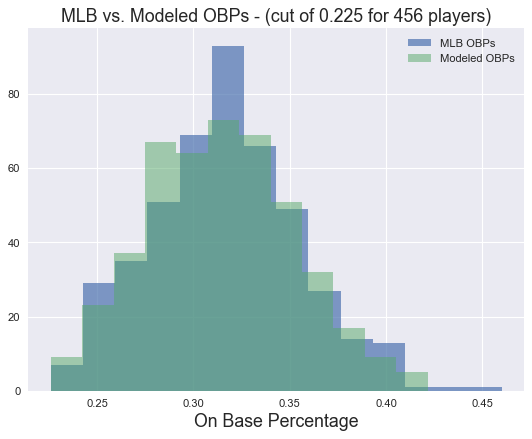

In [161]:
mean_obp, sigma = test_coeff[1], test_coeff[2]
P = stats.truncnorm(
    (lower_obp_cut - mean_obp) / sigma, (1 - mean_obp) / sigma, loc=mean_obp, scale=sigma)
test_lineup_obp = P.rvs(np.size(leaderboard.OBP[(leaderboard.OBP > lower_obp_cut) & (leaderboard.PA > pa_cut)]))
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(leaderboard.OBP[(leaderboard.OBP > lower_obp_cut) & (leaderboard.PA > pa_cut)], 'scott', alpha = 0.70)
plt.hist(test_lineup_obp, 'scott' , alpha = 0.5)
plt.title("MLB vs. Modeled OBPs - (cut of "+str(lower_obp_cut)+" for "+str(len(test_lineup_obp))+" players)", fontsize=16)
plt.xlabel("On Base Percentage", fontsize=16)  
labels= ["MLB OBPs","Modeled OBPs"]
plt.legend(labels)

The function *bern_obp* is used to decide, in each instance that it is called, whether the batter reaches base or not.  For example, if obp is 0.500, then bern_obp will return 0 half the times that is it called, and 1 the other half. 

In [81]:
def bern_obp(obp):
    ob = np.random.binomial(1, obp)
    return ob

The *game_simulation* function defined next is very basic: for 9 innings it steps through *lineup* and uses the Bernoulli function *bern_obp* to decide whether the batter is out or gets on base (effectively a base on ball).  Once 3 outs are reached, the inning turns over.  <br>
Output is a dictionary *innings* which stores the box score of each inning. Next we'll search them for streaks.  

In [82]:
def game_simulation(lineup, game_length = 9):
    bases = np.zeros(3)
    innings = {}
    batter = 0
    runs   = 0
    for inning in np.arange(game_length)+1:
        #print 'inning ', str(inning)
        plays = []
        outs = 0
        while outs <3:
            play = bern_obp(lineup[batter])
            #print play
            if play == 0: 
                outs+=1
            batter = batter+1
            if batter == 9: 
                batter = 0
            plays.extend([play])

        innings[inning] = plays
        
    return innings

Count the streaks (or clusters) and cluster lengths found in *innings* dictionaries. 

In [83]:
def on_base_streaks(innings, stepsize=0):
    cluster = []
    cluster_length = []
    for i in innings:
        streaks = np.split(innings[i], np.where(np.diff(innings[i]) != stepsize)[0]+1)
        for j in streaks:
            if (j[0] > 0) & (len(j) > 1):
                cluster.append(j)
                cluster_length.append(len(j))
        
    return cluster, cluster_length

Simple sum of total at-bats.   

In [84]:
def count_number_at_bats(box_score):
    tot_at_bats = np.sum(np.sum(box_score.values()))
    return tot_at_bats 

Simulate a full season by looping *game_simulation* 162 times. <br> 
Keep track of the box scores, number of streaks, and streak lengths in a dictionary named *season_stats*. <br>
Note, we estimate every 5th game is only 8 innings long (non walk-off home win).  

In [85]:
def team_season_simulation(lineup, season_length = 162):
    season_stats = {}
    season_stats['box'] = {}
    season_stats['streaks'] = {}
    season_stats['streak_lengths'] = {}
    # -- Estimate every 5th game is 8 innings --
    for g in np.arange(season_length)+1:
        if np.mod(g,5) == 0:
            game_length = 8
        else:
            game_length = 9
        
        season_stats['box'][g]     = game_simulation(lineup)
        season_stats['streaks'][g], season_stats['streak_lengths'][g]  = on_base_streaks(season_stats['box'][g])
    return season_stats

## Game Simulation

mean=0.3151772720894252
std=0.03900998389911308


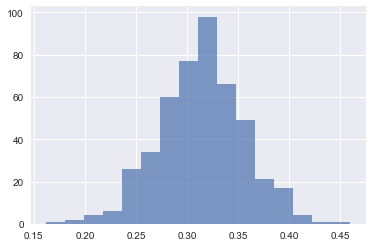

In [138]:
nsims = 5000

td_streak_count = np.zeros(nsims)
bu_streak_count = np.zeros(nsims)
td_total_hits   = np.zeros(nsims)
bu_total_hits   = np.zeros(nsims)

obp_model, coeffs_model = define_P(leaderboard)

for i in np.arange(nsims):
    lineup = draw_lineup(obp_model)
    bottom_up = np.sort(lineup['OBP'])
    top_down  = np.sort(lineup['OBP'])[::-1]

    bu_sim = team_season_simulation(bottom_up)
    bu_streak_count[i] = sum([len(bu_sim['streak_lengths'][x]) for x in bu_sim['streak_lengths']])
    bu_total_hits[i]   = sum([count_number_at_bats(bu_sim['box'][x]) for x in bu_sim['streak_lengths']])
    td_sim = team_season_simulation(top_down)
    td_streak_count[i] = sum([len(td_sim['streak_lengths'][x]) for x in td_sim['streak_lengths']])
    td_total_hits[i]   = sum([count_number_at_bats(td_sim['box'][x]) for x in td_sim['streak_lengths']])

## Results
First thing we'll look at is total number of times that a batter reached base in a season, for each simulation, for the bottom-up (green) and top-down (blue) lineups.  <br>
As you'd expect, on average, lineups where the better batters come first and thus have more opportunities to bat, get on base more often. 

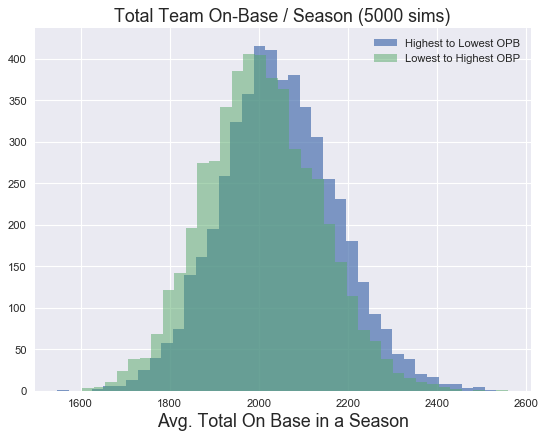

In [157]:
td_sim['box'][1]
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(td_total_hits, 'scott', alpha = 0.7)
plt.hist(bu_total_hits, 'scott', alpha = 0.5)
plt.title("Total Team On-Base / Season (5000 sims)", fontsize=16)
plt.xlabel("Avg. Total On Base in a Season", fontsize=16)  
plt.legend(labels)
labels= ["Highest to Lowest OPB","Lowest to Highest OBP"]

Howver, plotting the difference we find the advantage is not huge, with the peaks of the distributions off by less than 40.  Or an extra on-base every 4 games.  

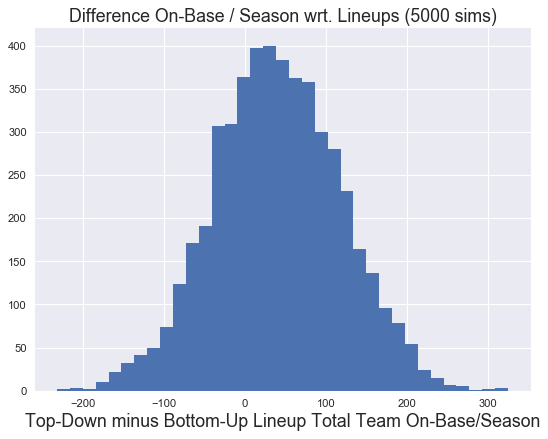

In [158]:
td_sim['box'][1]
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(td_total_hits - bu_total_hits, 'scott')
plt.title("Difference On-Base / Season wrt. Lineups (5000 sims)", fontsize=16)
plt.xlabel("Top-Down minus Bottom-Up Lineup Total Team On-Base/Season", fontsize=16)  
labels= ["Highest to Lowest OPB","Lowest to Highest OBP"]

What about **streaks**? <br>
Plotting number of streaks in a season we find similar behavoir favoring top-down OBPs.

<Figure size 432x288 with 0 Axes>

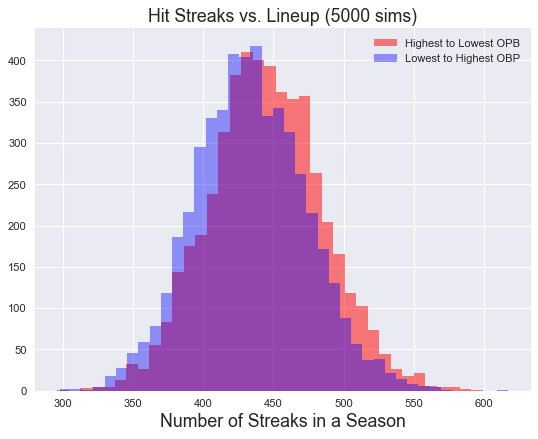

In [159]:
fig= plt.figure()
fig.patch.set_alpha(0.5)
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(td_streak_count, 'scott', alpha = 0.5, color = 'r')
plt.hist(bu_streak_count, 'scott',alpha = 0.4, color = 'b')
plt.title("Hit Streaks vs. Lineup (5000 sims)", fontsize=16)
plt.xlabel("Number of Streaks in a Season", fontsize=16)  
plt.legend(labels)
labels= ["Highest to Lowest OPB","Lowest to Highest OBP"]

And that the difference in total number of streaks peaks at around 10.  

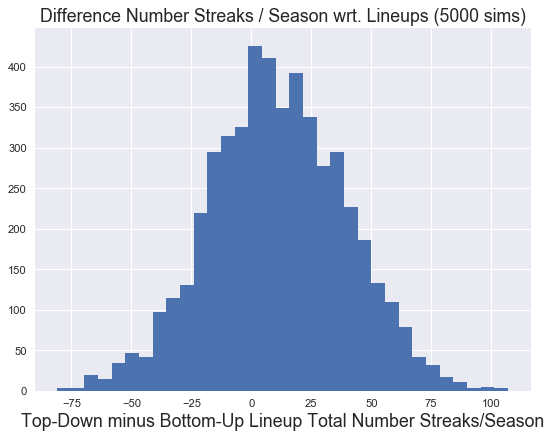

In [160]:
td_sim['box'][1]
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(td_streak_count - bu_streak_count, 'scott')
plt.title("Difference Number Streaks / Season wrt. Lineups (5000 sims)", fontsize=16)
plt.xlabel("Top-Down minus Bottom-Up Lineup Total Number Streaks/Season", fontsize=16)  
labels= ["Highest to Lowest OPB","Lowest to Highest OBP"]

### Conclusion
Batting order is not irrelevant, but as for reaching base more often, or for promoting hits in clusters, simple simulations indicate a small effect over a full season.  <br>

But this is need not be the end of the story.  This simulation does not take into account any covariances in the batting order; i.e., does the outcome of an at-bat effect the batter in front or behind them in the order?  And here at-bats are either outs or walks, what if more options are included?  <br>
This is the kind of simulation that gets built in stages, so, hang tight, more to come.  